# Using K-Mean for Iris Flower clustering

In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

In [2]:
iris_data = load_iris()

df = pd.DataFrame(
    iris_data.data, columns=iris_data.feature_names
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed_df = pca.fit_transform(df)

## K-means Clustering

In [4]:
def distance(X, centroids_list):    
    '''
        Input:
            - X: Data point
            - centroids_list: List of centroids
            
        Output:
            Distance from Data point to centroids
            
        How this Function work:
            For each centroid, compute the euclidean distance, then append to dis list
    '''
    dis: list = []
    for centroid in centroids_list:
        dis.append(np.sum(np.square(X - centroid)))
    return dis

In [5]:
def re_label(X, centroids_list):

    '''
        Input: 
            - X: Data point
            - centroids_list: List of centroids
            
        Output: 
            [1]: True if the label was updated
            [2]: The data point
            
        How this Function work:
            Line 18: Compute the distance from data point to each centroid
            Line 19: Find the label which has min distance to data point
            Line 21-23: Check if new nearest centroid change, then update
    '''
    re = False
    # Compute distance fron data point to centroids
    dis = distance(X[:-1], centroids_list)
    new_label = np.argmin(dis)
    if new_label != int(X[-1]):
        X[-1] = new_label
        re = True
        
    return re, X

In [6]:
def WCV(X):
    '''
        Input:
            - X: Set of data points in the same cluster
        
        Output:
            Within Cluster Variance
            
        How this Function work:
            Compute the sum of distance of two data point for each feature after squared. Then divided by Cluster set size
    '''
    total_sum = 0
    for first_point in X:
        for second_point in X:
            total_sum += np.sum(np.square(first_point - second_point), axis=0)
            
    return total_sum / X.shape[0]

In [7]:

def k_mean_cluster(X: np.ndarray, k_clusters: int):
    '''
        Input:
            - X: Numerical data has shape (D, N) where N is number of samples and D is number of features
            - k_clusters: number of clusters for clustering
    
        Output:
            Matrix R has shape (N, D + 1) where N is number of samples, D features and 1 label colums for cluster
            
        Variables:
            - lables: Random label 
            - Result: Whole data set add 1 label column
            - Cost_per_iter: total WCV for each iteration
            - is_re_label: Check whether any data point was re labeled
            - iter: iteration
            - cluster_set: Set of data points have the same label
            - centroids_list: List of centroids
        
        How this Function work:
            Line 34 - 35: Assign random labels for dataset with Uniform distribution
            Line 43 - 36: Modify centroid position for each cluster
            Line 51 - 56: Relabel after centroids position have changed
            Line 59 - 61: Compute the total WCF for current iteration 
            
    '''
    
    cost_per_iter = []
    is_re_label = True
    centroids_list = np.zeros(shape=(k_clusters, X.shape[0]))
    iter = 0
    
    # Assignments
    labels = np.random.choice(k_clusters, X.shape[1]).reshape(1, -1)
    result = np.r_[X, np.array(labels)]

    while is_re_label:
        is_re_label = False
        iter += 1
        # Compute Centroids
        for cluster in range(k_clusters):
            # Cluster_set has shape (D, Ck) where D is the number of features and Ck is the number of points in cluster K
            cluster_set = result.T[result[-1, :] == float(cluster)][:, :-1].T
            
            # Centroids_list[cluster] has D float numberz for D features
            centroids_list[cluster] = cluster_set.mean(axis=1)
            

        # Relabel
        
        for i in range(X.shape[1]):
            # Re is True if point ith assigned new label
            re, result[:, i] = re_label(result[:, i], centroids_list)
            
            if re:
                is_re_label = True

        cost_per_iter.append(0)
        for cluster in range(k_clusters):
            cluster_set = result.T[result[-1, :] == float(cluster)][:, :2]
            cost_per_iter[-1] += WCV(cluster_set)
        
    return result, centroids_list, iter, cost_per_iter

Text(0.5, 1.0, 'Within Cluster Variance change through iteration')

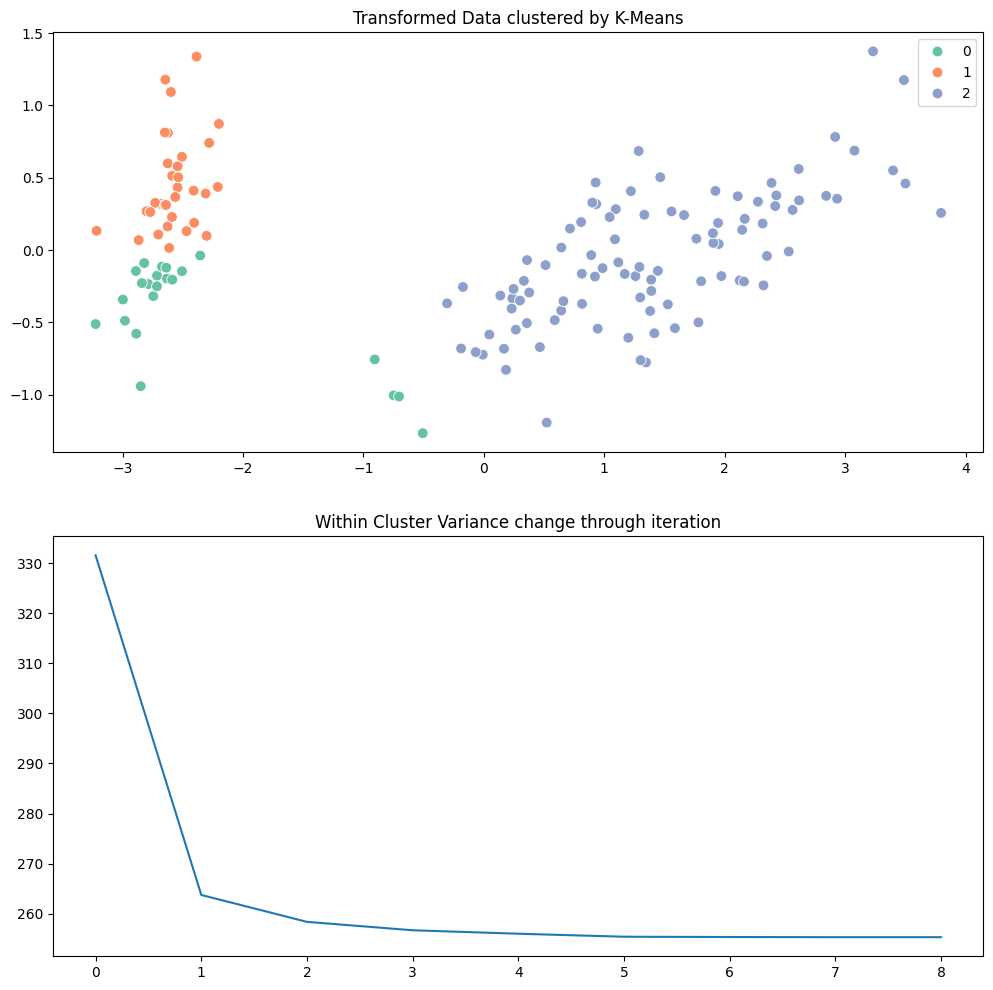

In [8]:
result, centroids, iter, cost_per_iter = k_mean_cluster(transformed_df.T, 3)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

g = sns.scatterplot(x=result[0], y=result[1], hue=result[2].astype(int), palette='Set2', ax=axes[0], s=60)
g.set_title("Transformed Data clustered by K-Means")
g = sns.lineplot(x=range(iter), y=cost_per_iter, ax=axes[1])
g.set_title("Within Cluster Variance change through iteration")

# Compare with Sklearn

c:\Users\hoang\AppData\Local\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Transformed Data clustered by K-Means (Sklearn)')

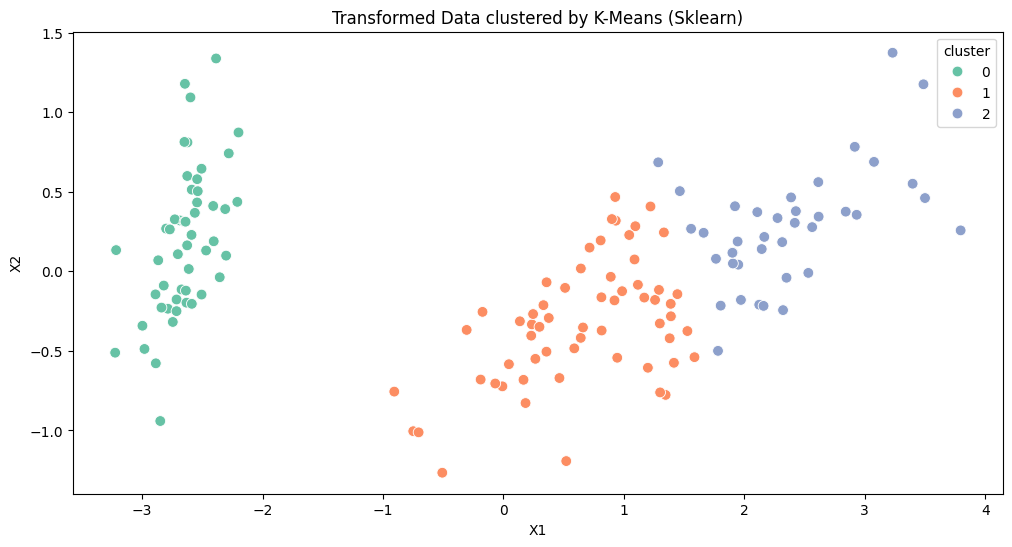

In [9]:
# Test sklearn
from sklearn.cluster import KMeans
temp = transformed_df.copy()
kmean = KMeans(n_clusters=3).fit(temp)
clusters = kmean.predict(temp)

sk_result = {
    'X1': temp[:, 0],
    'X2': temp[:, 1],
    'cluster': clusters
}

sk_result = pd.DataFrame(sk_result)
plt.figure(figsize=(12, 6))
g = sns.scatterplot(x=sk_result.X1, y=sk_result.X2, hue=sk_result.cluster.astype(int), palette='Set2', s=60)
g.set_title("Transformed Data clustered by K-Means (Sklearn)")

# Compare Centroids Position

In [10]:
kmean_centroids = kmean.cluster_centers_
kmean_centroids.sort(axis=0)
centroids.sort(axis=0)

mean_square_error = np.mean((centroids - kmean_centroids) ** 2)
print(f"{mean_square_error = }")

mean_square_error = 1.7274003766533683


Text(0.5, 1.0, 'Sklearn')

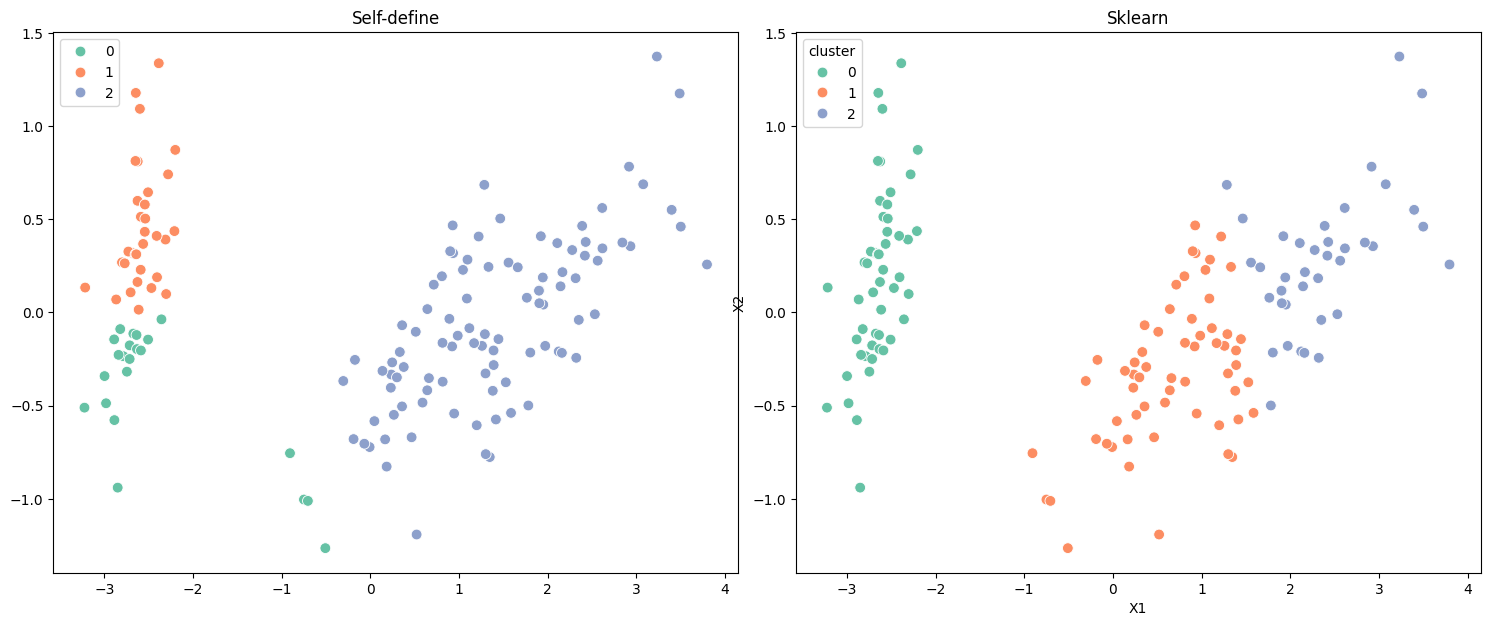

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.tight_layout()

g = sns.scatterplot(x=result[0], y=result[1], hue=result[2].astype(int), palette='Set2', s=60, ax=axes[0])
g.set_title("Self-define")


g = sns.scatterplot(x=sk_result.X1, y=sk_result.X2, hue=sk_result.cluster.astype(int), palette='Set2', s=60, ax=axes[1]);
g.set_title("Sklearn")